# Clustering of the Neighborhoods of Cities Popular in Media
Heejoon Ahn  
February 20, 2021

## 1. Introduction and Business Problem

London and New York are two of the popular locations for tourism as of late for many fans of different media types. For London, people have traveled not only for sightseeing, but also for the famous locations from novels, movies, and television shows. Some popular examples include the original *Sherlock Holmes* stories, the television adaptation *Sherlock*, *Doctor Who*, *Harry Potter*,and many more. Especially with the widespread fame of *Sherlock Holmes, Doctor Who, and Harry Potter*, the entertainment industry in England has even further catered to generate events like the popular Escape Rooms based on these stories to bring in fans from across the globe to London. 

For New York City, people have mostly traveled there for some of the sightseeing in Manhattan such as Times Square. However, the city itself has been displayed in several stories and movies. The recently most popular series taking place in New York City is Marvel's *Avengers* series and *Spiderman* series. Some of the earlier 2000's movies have been successful in bringing in people such as the *Devil Wear's Prada* movie and even the Christmas family movie *Elf*. 

With the influence of such media and the fans, the tourism in both cities from influence of media sources cannot be discredited. With this in mind, the goal of this project is to generate a way to help tourists visiting both cities to choose their destinations depending on the experiences and services available in respective cities and its neighborhoods.

## 2. Data Description

### 2.1 London Data
The data for London was retrieved from two different sources. One was from Wikipedia's web page looking at the different areas within the city. We will be scraping the data from the website (https://en.wikipedia.org/wiki/List_of_areas_of_London). 

This page provides the following sets of information in the relevant table we will be scraping:
1. Neighborhood 
2. Borough
3. Town 
4. Postal Code District

However, the table that we will be scraping does lack the information regarding latitude and longitude, which we need to generate the maps for our clustering methods. To retrieve them, we utilize the **ArcGIS API**. ArcGIS Online allows users to connect data regarding people and locations with interactive maps. This API will be used to help retrieve the latitudes and longitudes for this dataset. 

### 2.2 New York Data
The data for New York City will be retrieved from the data provided by previous coursework that introduced the New York City clustering methods. Therefore, the retrieving of data will follow the code from the ungraded lab: **Segmenting and Clustering Neighborhoods in New York City**. The information that is provided from this dataset is 

1. Neighborhood
2. Borough
3. Latitude
4. Longitude


### 2.3 Foursquare API
To retrieve the information of the various venues within certain neighborhoods, we will be using the **Foursquare API**. Foursquare, being a location data provider, has information on venue names, locations, menus and more. For our purposes, we will be connecting to the API to retrieve the list of venues from all neighborhoods in respective cities. The radius that the API will be looking at was designated as 500 meters. 

The data retrieved from Foursquare contained information of venues within a specified distance of the longitude and latitude of the postcodes. The information obtained per venue as follows:
1. Neighbourhood : Name of the Neighbourhood
2. Neighbourhood Latitude : Latitude of the Neighbourhood
3. Neighbourhood Longitude : Longitude of the Neighbourhood
4. Venue : Name of the Venue
5. Venue Latitude : Latitude of Venue
6. Venue Longitude : Longitude of Venue
7. Venue Category : Category of Venue

## 3. Methodology
The first step, before doing anything of interest, will be to load in the necessary packages to do our work. The packages are loaded as shown in the code below:

In [1]:
# loading packages
import pandas as pd
import numpy as np
import requests
import json
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
from arcgis.geocoding import geocode
from arcgis.gis import GIS
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
from sklearn.cluster import KMeans

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/arcgis/features/_data/geodataset/utils.py:16: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  pd.datetime,


The packages that have been loaded perform the following:

* **Pandas**: hande data analysis
* **Numpy**: handle data in a vectorized manner 
* **requests**: handle requests
* **json**: handle JSON files 
* **Nominatim**: convert an address into latitude and longitude values
* **json_normalize**: tranform JSON file into a pandas dataframe
* **matplotlib**: help to generate the maps in our project. 
* **folium**: map rendering library
* **KMeans**: The machine learning model that we are using.

The main approach was to first explore the cities individually, plot their maps to show the neighborhoods, build the models by clustering all of the similar neighborhoods together and finally plot the new maps with the clustered neighborhoods. Afterwards, the discussion of the findings is made. 

### 3.1 Data Collection 
To start the data collection, the first step we implemented was to scrape the data required for London and New York City. For London, we required information including postal codes, neighborhoods, and boroughs. Because the information is mostly provided on the wikipedia page, we scraped using the following steps: 

In [2]:
london_wiki = "https://en.wikipedia.org/wiki/List_of_areas_of_London"
london_url = requests.get(london_wiki)
london_df = pd.read_html(london_url.text)
london_df = london_df[1]
london_df

Location                     London borough       Post town  \
0         Abbey Wood              Bexley, Greenwich [7]          LONDON   
1              Acton  Ealing, Hammersmith and Fulham[8]          LONDON   
2          Addington                         Croydon[8]         CROYDON   
3         Addiscombe                         Croydon[8]         CROYDON   
4        Albany Park                             Bexley  BEXLEY, SIDCUP   
..               ...                                ...             ...   
526         Woolwich                          Greenwich          LONDON   
527   Worcester Park       Sutton, Kingston upon Thames  WORCESTER PARK   
528  Wormwood Scrubs             Hammersmith and Fulham          LONDON   
529          Yeading                         Hillingdon           HAYES   
530         Yiewsley                         Hillingdon    WEST DRAYTON   

    Postcode district Dial code OS grid ref  
0                 SE2       020    TQ465785  
1              W3, W4       020    TQ205805  
2                 CR0       020    TQ375645  
3                 CR0       020    TQ345665  
4           DA5, DA14       020    TQ478728  
..                ...       ...         ...  
526              SE18       020    TQ435795  
527               KT4       020    TQ225655  
528               W12       020    TQ225815  
529               UB4       020    TQ115825  
530               UB7       020    TQ063804  

[531 rows x 6 columns]

For New York City, the information was provided in a previous lab in this course, so the data was retrieved in a similar fashion to what was provided in the lab notebook. 

In [3]:
# retrieving NYC data from provided json file
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
# getting the neighborhoods data
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

# fill the dataframe
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
neighborhoods.head()

Data downloaded!


Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

In [4]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]))

The dataframe has 5 boroughs and 306 neighborhoods.


### 3.2 Data Preprocessing
For London, the spaces are replaced with underscores in the title. In the borough column of the dataframe, there are numbers within square brackets that will need to be removed. First the column name types are double checked since not all the spaces are just simple spaces. Some of them are \xa0, which is then replaced with an underscore in a similar fashion as the spaces. Then the first and second columns were renamed respectively to Neighbourhood and Borough. Later, the square brackets and the numbers inside them are removed for the borough column. 

In [5]:
print(list(london_df.columns))

['Location', 'London\xa0borough', 'Post town', 'Postcode\xa0district', 'Dial\xa0code', 'OS grid ref']


In [6]:
london_df.rename(columns=lambda x: x.strip().replace(" ", "_"), inplace=True)
london_df.rename(columns=lambda x:x.strip().replace("\xa0", "_"), inplace=True)
london_df.rename(columns={'Location':'Neighborhood', 'London_borough':'Borough', 'Post_town': 'Town'}, inplace=True)
london_df['Borough'] = london_df['Borough'].map(lambda x:x.rstrip(']').rstrip('0123456789').rstrip('['))
london_df.head(10)

Neighborhood                         Borough            Town  \
0        Abbey Wood              Bexley, Greenwich           LONDON   
1             Acton  Ealing, Hammersmith and Fulham          LONDON   
2         Addington                         Croydon         CROYDON   
3        Addiscombe                         Croydon         CROYDON   
4       Albany Park                          Bexley  BEXLEY, SIDCUP   
5  Aldborough Hatch                       Redbridge          ILFORD   
6           Aldgate                            City          LONDON   
7           Aldwych                     Westminster          LONDON   
8          Alperton                           Brent         WEMBLEY   
9           Anerley                         Bromley          LONDON   

  Postcode_district Dial_code OS_grid_ref  
0               SE2       020    TQ465785  
1            W3, W4       020    TQ205805  
2               CR0       020    TQ375645  
3               CR0       020    TQ345665  
4         DA5, DA14       020    TQ478728  
5               IG2       020    TQ455895  
6               EC3       020    TQ334813  
7               WC2       020    TQ307810  
8               HA0       020    TQ185835  
9              SE20       020    TQ345695

For New York City, because the data had to be filled out properly in our data collection, this step could be overlooked for the most part. 

### 3.3 Feature Selection
In both of our datasets, we really only require the borough, neighborhood, and geolocations. However, for London, we also need the postal codes to be able to successfully retrieve the geolocations (latitude and longitude). Because the New York City data already has the proper data, we only need to retrieve the relevant columns from the London dataset. 

In [7]:
london_data = london_df.drop([london_df.columns[0],london_df.columns[4], london_df.columns[5]], axis=1)
london_data.head(10)

Borough            Town Postcode_district
0              Bexley, Greenwich           LONDON               SE2
1  Ealing, Hammersmith and Fulham          LONDON            W3, W4
2                         Croydon         CROYDON               CR0
3                         Croydon         CROYDON               CR0
4                          Bexley  BEXLEY, SIDCUP         DA5, DA14
5                       Redbridge          ILFORD               IG2
6                            City          LONDON               EC3
7                     Westminster          LONDON               WC2
8                           Brent         WEMBLEY               HA0
9                         Bromley          LONDON              SE20

### 3.4 Feature Engineering
With the selected features of interest, the next step is to retrieve the latitude and longitude values for London (since we already have them in the data collection step for New York City). Because there are two borough columns provided here, to simplify our dataset for London, we are going to extract just LONDON from the Borough column since the London_borough already has the unique borough values. 

For New York City, we are just going to use all boroughs that are listed for the sake of analysis. 

In [8]:
# retrieving data for just london 
london = london_data[london_data['Town'].str.contains('LONDON')].reset_index(drop=True)
london.head()

Borough    Town Postcode_district
0              Bexley, Greenwich   LONDON               SE2
1  Ealing, Hammersmith and Fulham  LONDON            W3, W4
2                            City  LONDON               EC3
3                     Westminster  LONDON               WC2
4                         Bromley  LONDON              SE20

For London, we now then retrieve the latitude and longitude data from the ArcGIS API. For New York, the the latitude and longitude is retrieved using the Nominatim() function and geolocator.geocode(). 

In [10]:
# for London
gis = GIS()

In [11]:
def get_geo_UK(address_input):
    lat = 0
    lon = 0
    g = geocode(address='{}, London, England, GBR'.format(address_input))[0]
    lon = g['location']['x']
    lat = g['location']['y']
    return str(lat) + "," + str(lon)

In [12]:
# pass postal codes of london 
coordinates_uk = london['Postcode_district']
# coordinates_uk

In [13]:
coordinates_london = coordinates_uk.apply(lambda x: get_geo_UK(x))
# coordinates_london

In [14]:
# retrieve latitude and longitude
lat_uk = coordinates_london.apply(lambda x: x.split(',')[0])
lon_uk = coordinates_london.apply(lambda x: x.split(',')[1])

In [15]:
london_merged = pd.concat([london, lat_uk.astype(float), lon_uk.astype(float)], axis=1)
london_merged.columns = ['Borough', 'Town', 'post_code', 'latitude', 'longitude']
london_merged.head()

Borough    Town post_code  latitude  longitude
0              Bexley, Greenwich   LONDON       SE2  51.49245    0.12127
1  Ealing, Hammersmith and Fulham  LONDON    W3, W4  51.51324   -0.26746
2                            City  LONDON       EC3  51.51200   -0.08058
3                     Westminster  LONDON       WC2  51.51651   -0.11968
4                         Bromley  LONDON      SE20  51.41009   -0.05683

In [16]:
london_geo = geocode(address = "London, England, GBR")[0]
london_lng = london_geo['location']['x']
london_lat = london_geo['location']['y']
print("The geographical coordinates of London are {}, {} ".format(london_lat, london_lng))

The geographical coordinates of London are 51.50642000000005, -0.1272099999999341 


In [71]:
# for new york
ny_address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
ny_location = geolocator.geocode(ny_address)
ny_latitude = ny_location.latitude
ny_longitude = ny_location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(ny_latitude, ny_longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


### 3.5 Visualize the Neighborhoods of London and New York City
Since the datasets are fully loaded and cleaned, we can use the Folium package to visulize the neighborhoods of both London and New York City. 

The following is for London: 

In [116]:
# map for London
map_London = folium.Map(location=[london_lat, london_lng], zoom_start = 11)
map_London

# add markers
for latitude, longitude, borough, town in zip(london_merged['latitude'], london_merged['longitude'], london_merged['Borough'], london_merged['Town']):
    label= '{}, {}'.format(town, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color="red",
        fill=True,
    ).add_to(map_London)
    
map_London

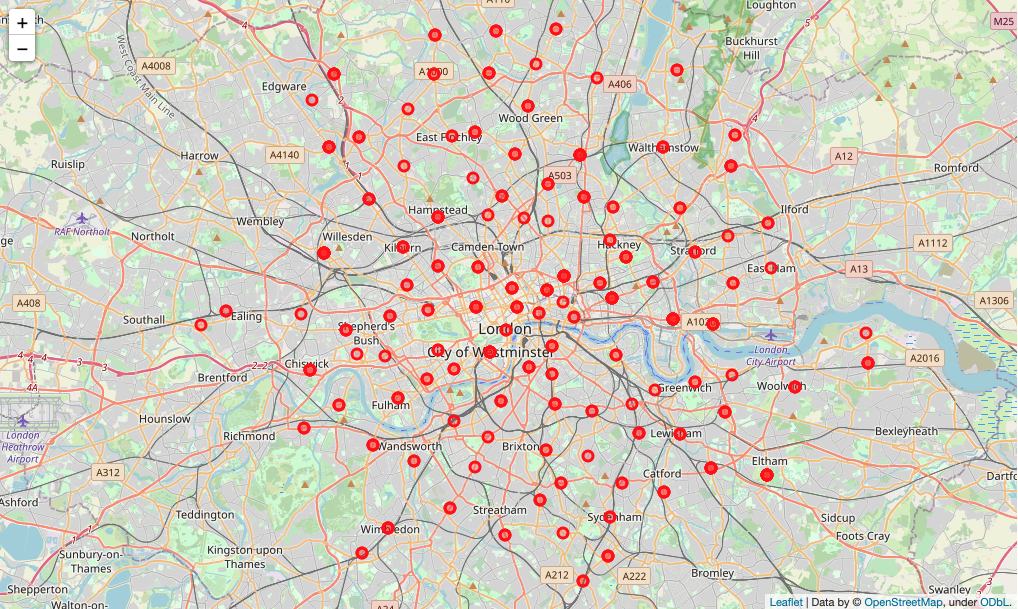

Map for New York City, New York: 

In [73]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

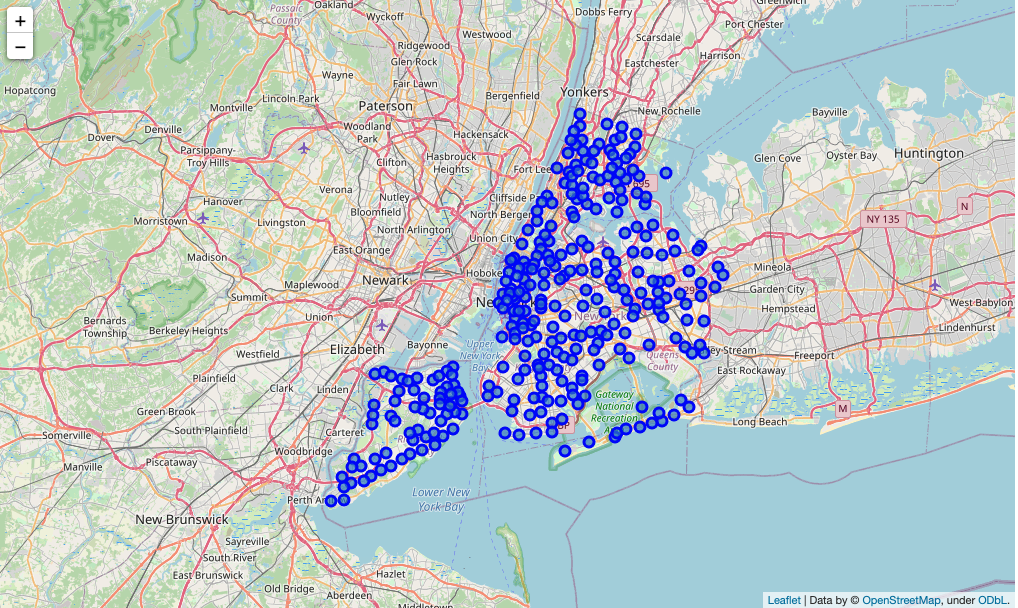

Now that the maps have been drawn with the neighborhoods, we need to find what each of the neighborhoods is like within the appropriate locations. Especially by looking at common venues and venue categories within the 500 meter radius. We do this using Foursquare. A function is generated to help get the information pertaining to each neighborhood including the name of the neighborhood, coordinates, venue, and venue category. The code is written below:

In [20]:
# credentials for foursquare:
CLIENT_ID = 'ACWA2C5E0E0JEKVGH3IKPHZY0J1HS0WO0PGN3AJXZEOEOCTO' # your Foursquare ID
CLIENT_SECRET = 'OOJNLA0NXIP1NGFY0WU5FHX5DFDGRVG3BVQDAXYUBZIGAI2R' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ACWA2C5E0E0JEKVGH3IKPHZY0J1HS0WO0PGN3AJXZEOEOCTO
CLIENT_SECRET:OOJNLA0NXIP1NGFY0WU5FHX5DFDGRVG3BVQDAXYUBZIGAI2R


In [21]:
LIMIT = 100
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [22]:
# Getting venues in london
london_venues = getNearbyVenues(london_merged['Borough'], london_merged['latitude'], london_merged['longitude'])

Bexley, Greenwich 
Ealing, Hammersmith and Fulham
City
Westminster
Bromley
Islington
Islington
Barnet
Enfield
Wandsworth
Southwark
City
Richmond upon Thames
Barnet
Islington
Wandsworth
Westminster
Bromley
Newham
Ealing
Westminster
Lewisham
Camden
Southwark
Tower Hamlets
Bexley
City
Lewisham
Greenwich
Tower Hamlets
Camden
Haringey
Tower Hamlets
Haringey
Barnet
Brent
Lambeth
Lewisham
Tower Hamlets
Kensington and Chelsea, Hammersmith and Fulham
Brent
Barnet
Barnet
Southwark
Tower Hamlets
Camden
Tower Hamlets
Waltham Forest
Newham
Islington
Richmond upon Thames
Lewisham
Camden
Westminster
Greenwich
Kensington and Chelsea
Barnet
Westminster
Lewisham
Waltham Forest
Hounslow, Ealing, Hammersmith and Fulham
Brent
Barnet
Lambeth, Wandsworth
Islington
Barnet
Merton
Barnet
Westminster
Barnet, Brent, Camden
Lewisham
Bexley
Haringey
Bromley
Tower Hamlets
Newham
Hackney
Islington
Southwark
Lewisham
Brent
Southwark
Ealing
Kensington and Chelsea
Wandsworth
Southwark
Barnet
Newham
Richmond upon Thames


In [23]:
london_venues.head() # sampling

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Bexley, Greenwich                51.49245                 0.12127   
1  Bexley, Greenwich                51.49245                 0.12127   
2  Bexley, Greenwich                51.49245                 0.12127   
3  Bexley, Greenwich                51.49245                 0.12127   
4  Bexley, Greenwich                51.49245                 0.12127   

                              Venue  Venue Latitude  Venue Longitude  \
0                      Lesnes Abbey       51.489526         0.125839   
1                       Sainsbury's       51.492826         0.120524   
2                              Lidl       51.496152         0.118417   
3  Abbey Wood Railway Station (ABW)       51.490825         0.123432   
4                        Costcutter       51.491287         0.120938   

      Venue Category  
0      Historic Site  
1        Supermarket  
2        Supermarket  
3      Train Station  
4  Convenience Store

In [24]:
london_venues.shape

(10233, 7)

In [76]:
# getting the venues in Manhattan
NY_venues = getNearbyVenues(neighborhoods['Neighborhood'], neighborhoods['Latitude'], neighborhoods['Longitude'])

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [77]:
NY_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Wakefield              40.894705              -73.847201   
1    Wakefield              40.894705              -73.847201   
2    Wakefield              40.894705              -73.847201   
3    Wakefield              40.894705              -73.847201   
4    Wakefield              40.894705              -73.847201   

              Venue  Venue Latitude  Venue Longitude  Venue Category  
0  Lollipops Gelato       40.894123       -73.845892    Dessert Shop  
1          Rite Aid       40.896649       -73.844846        Pharmacy  
2         Walgreens       40.896528       -73.844700        Pharmacy  
3  Carvel Ice Cream       40.890487       -73.848568  Ice Cream Shop  
4           Dunkin'       40.890459       -73.849089      Donut Shop

The next step would be to take the two dataframes of the venues for both cities and group them by venue categories. This is done by using the .groupby() in python.  

In [27]:
# for London
london_venues.groupby('Venue Category').max()

Neighborhood  Neighborhood Latitude  \
Venue Category                                                       
Accessories Store               Westminster               51.51656   
Adult Boutique                    Islington               51.52969   
African Restaurant              Westminster               51.52587   
American Restaurant          Waltham Forest               51.61780   
Antique Shop                    Westminster               51.51651   
...                                     ...                    ...   
Wings Joint          Hammersmith and Fulham               51.54187   
Women's Store                   Westminster               51.55457   
Xinjiang Restaurant               Southwark               51.47480   
Yoga Studio                     Westminster               51.55457   
Zoo Exhibit                          Camden               51.53354   

                     Neighborhood Longitude                        Venue  \
Venue Category                                                             
Accessories Store                  -0.11968           James Smith & Sons   
Adult Boutique                     -0.08697  Sh! Women's Erotic Emporium   
African Restaurant                 -0.08808           Red Sea Restaurant   
American Restaurant                 0.02795                  Spielburger   
Antique Shop                       -0.11968     The London Silver Vaults   
...                                     ...                          ...   
Wings Joint                        -0.19795                     Wingmans   
Women's Store                      -0.11478           Vivien of Holloway   
Xinjiang Restaurant                -0.09313                    Silk Road   
Yoga Studio                        -0.03558                    yogahaven   
Zoo Exhibit                        -0.14606                Penguin Beach   

                     Venue Latitude  Venue Longitude  
Venue Category                                        
Accessories Store         51.516902        -0.126843  
Adult Boutique            51.527102        -0.083728  
African Restaurant        51.523967        -0.080917  
American Restaurant       51.617790         0.024169  
Antique Shop              51.517145        -0.112608  
...                             ...              ...  
Wings Joint               51.545554        -0.202021  
Women's Store             51.554454        -0.114362  
Xinjiang Restaurant       51.473820        -0.089284  
Yoga Studio               51.551300        -0.029378  
Zoo Exhibit               51.535481        -0.151430  

[294 rows x 6 columns]

There are a total of 294 records, indicating how diverse and interesting London is! 

In [78]:
# for Manhattan
NY_venues.groupby('Venue Category').max()

Neighborhood  Neighborhood Latitude  \
Venue Category                                                  
Accessories Store   Washington Heights              40.874294   
Adult Boutique            West Village              40.823604   
Afghan Restaurant               Utopia              40.768113   
African Restaurant  University Heights              40.860997   
Airport Terminal           Brownsville              40.737251   
...                                ...                    ...   
Wine Bar                     Yorkville              40.867684   
Wine Shop                    Yorkville              40.867684   
Wings Joint                  Yorkville              40.881687   
Women's Store       Washington Heights              40.860997   
Yoga Studio               Williamsburg              40.876551   

                    Neighborhood Longitude  \
Venue Category                               
Accessories Store               -73.735261   
Adult Boutique                  -73.949688   
Afghan Restaurant               -73.796717   
African Restaurant              -73.896427   
Airport Terminal                -73.910235   
...                                    ...   
Wine Bar                        -73.774274   
Wine Shop                       -73.720128   
Wings Joint                     -73.738898   
Women's Store                   -73.776802   
Yoga Studio                     -73.754950   

                                                    Venue  Venue Latitude  \
Venue Category                                                              
Accessories Store                     Venus by Maria Tash       40.873286   
Adult Boutique            The Pleasure Chest New York UES       40.822130   
Afghan Restaurant                      Sami's Kebab House       40.768021   
African Restaurant                    Ponty Bistro Harlem       40.857407   
Airport Terminal    La Guardia terminal (A) Delta Shuttle       40.739781   
...                                                   ...             ...   
Wine Bar                                             bibi       40.868032   
Wine Shop                                         convive       40.867251   
Wings Joint                                      Wingstop       40.884460   
Women's Store                               The Brass Owl       40.862430   
Yoga Studio                                  mang'Oh yoga       40.876844   

                    Venue Longitude  
Venue Category                       
Accessories Store        -73.732963  
Adult Boutique           -73.952967  
Afghan Restaurant        -73.794645  
African Restaurant       -73.899738  
Airport Terminal         -73.909841  
...                             ...  
Wine Bar                 -73.771557  
Wine Shop                -73.716195  
Wings Joint              -73.736690  
Women's Store            -73.775622  
Yoga Studio              -73.754943  

[440 rows x 6 columns]

For Manhattan, though there is a significantly smaller number of neighborhoods than London, has 334 records, hinting that it is even more diverse than London!

### 3.6 One Hot Encoding

Since our object is to determine what distinctive venue categories there are in each neighborhood (and then calculate the top 10 common venues) we use One Hot Encoding. This is used to help with categorical data types of the venue categories. This will help with converting the categorica ldata into numeric data. 

For both London and New York, we will use one hot encoding and then calculate the mean of the grouped venue categories for each of the neighborhoods. 

In [29]:
# One hot encoding for London
london_venue_cat = pd.get_dummies(london_venues[['Venue Category']], prefix = "", prefix_sep="")
london_venue_cat

Accessories Store  Adult Boutique  African Restaurant  \
0                      0               0                   0   
1                      0               0                   0   
2                      0               0                   0   
3                      0               0                   0   
4                      0               0                   0   
...                  ...             ...                 ...   
10228                  0               0                   0   
10229                  0               0                   0   
10230                  0               0                   0   
10231                  0               0                   0   
10232                  0               0                   0   

       American Restaurant  Antique Shop  Arcade  Arepa Restaurant  \
0                        0             0       0                 0   
1                        0             0       0                 0   
2                        0             0       0                 0   
3                        0             0       0                 0   
4                        0             0       0                 0   
...                    ...           ...     ...               ...   
10228                    0             0       0                 0   
10229                    0             0       0                 0   
10230                    0             0       0                 0   
10231                    0             0       0                 0   
10232                    0             0       0                 0   

       Argentinian Restaurant  Art Gallery  Art Museum  ...  \
0                           0            0           0  ...   
1                           0            0           0  ...   
2                           0            0           0  ...   
3                           0            0           0  ...   
4                           0            0           0  ...   
...                       ...          ...         ...  ...   
10228                       0            0           0  ...   
10229                       0            0           0  ...   
10230                       0            0           0  ...   
10231                       0            0           0  ...   
10232                       0            0           0  ...   

       Vietnamese Restaurant  Warehouse Store  Whisky Bar  Wine Bar  \
0                          0                0           0         0   
1                          0                0           0         0   
2                          0                0           0         0   
3                          0                0           0         0   
4                          0                0           0         0   
...                      ...              ...         ...       ...   
10228                      0                0           0         0   
10229                      0                0           0         0   
10230                      0                0           0         0   
10231                      0                0           0         0   
10232                      0                0           0         0   

       Wine Shop  Wings Joint  Women's Store  Xinjiang Restaurant  \
0              0            0              0                    0   
1              0            0              0                    0   
2              0            0              0                    0   
3              0            0              0                    0   
4              0            0              0                    0   
...          ...          ...            ...                  ...   
10228          0            0              0                    0   
10229          0            0              0                    0   
10230          0            0              0                    0   
10231          0            0              0                    0   
10232          0            

In [30]:
# add neighborhoods
london_venue_cat['Neighborhood'] = london_venues['Neighborhood']

# move neighborhood column as first column
fixed_columns = [london_venue_cat.columns[-1]] + list(london_venue_cat.columns[:-1])
london_venue_cat = london_venue_cat[fixed_columns]
london_venue_cat.head()

Neighborhood  Accessories Store  Adult Boutique  African Restaurant  \
0  Bexley, Greenwich                   0               0                   0   
1  Bexley, Greenwich                   0               0                   0   
2  Bexley, Greenwich                   0               0                   0   
3  Bexley, Greenwich                   0               0                   0   
4  Bexley, Greenwich                   0               0                   0   

   American Restaurant  Antique Shop  Arcade  Arepa Restaurant  \
0                    0             0       0                 0   
1                    0             0       0                 0   
2                    0             0       0                 0   
3                    0             0       0                 0   
4                    0             0       0                 0   

   Argentinian Restaurant  Art Gallery  ...  Vietnamese Restaurant  \
0                       0            0  ...                      0   
1                       0            0  ...                      0   
2                       0            0  ...                      0   
3                       0            0  ...                      0   
4                       0            0  ...                      0   

   Warehouse Store  Whisky Bar  Wine Bar  Wine Shop  Wings Joint  \
0                0           0         0          0            0   
1                0           0         0          0            0   
2                0           0         0          0            0   
3                0           0         0          0            0   
4                0           0         0          0            0   

   Women's Store  Xinjiang Restaurant  Yoga Studio  Zoo Exhibit  
0              0                    0            0            0  
1              0                    0            0            0  
2              0                    0            0            0  
3              0                    0            0            0  
4              0                    0            0            0  

[5 rows x 295 columns]

In [31]:
# calculate the mean values for venue categories
london_grouped = london_venue_cat.groupby('Neighborhood').mean().reset_index()
london_grouped.head()

Neighborhood  Accessories Store  Adult Boutique  \
0                 Barnet                0.0             0.0   
1  Barnet, Brent, Camden                0.0             0.0   
2                 Bexley                0.0             0.0   
3      Bexley, Greenwich                0.0             0.0   
4     Bexley, Greenwich                 0.0             0.0   

   African Restaurant  American Restaurant  Antique Shop  Arcade  \
0                 0.0             0.001912           0.0     0.0   
1                 0.0             0.000000           0.0     0.0   
2                 0.0             0.000000           0.0     0.0   
3                 0.0             0.000000           0.0     0.0   
4                 0.0             0.000000           0.0     0.0   

   Arepa Restaurant  Argentinian Restaurant  Art Gallery  ...  \
0               0.0                0.007648          0.0  ...   
1               0.0                0.000000          0.0  ...   
2               0.0                0.000000          0.0  ...   
3               0.0                0.000000          0.0  ...   
4               0.0                0.000000          0.0  ...   

   Vietnamese Restaurant  Warehouse Store  Whisky Bar  Wine Bar  Wine Shop  \
0               0.007648              0.0         0.0       0.0        0.0   
1               0.000000              0.0         0.0       0.0        0.0   
2               0.000000              0.0         0.0       0.0        0.0   
3               0.000000              0.0         0.0       0.0        0.0   
4               0.000000              0.0         0.0       0.0        0.0   

   Wings Joint  Women's Store  Xinjiang Restaurant  Yoga Studio  Zoo Exhibit  
0          0.0            0.0                  0.0          0.0          0.0  
1          0.0            0.0                  0.0          0.0          0.0  
2          0.0            0.0                  0.0          0.0          0.0  
3          0.0            0.0                  0.0          0.0          0.0  
4          0.0            0.0                  0.0          0.0          0.0  

[5 rows x 295 columns]

In [79]:
# for Manhattan, do the same:
ny_venue_cat = pd.get_dummies(NY_venues[['Venue Category']], prefix = "", prefix_sep="")
ny_venue_cat

Accessories Store  Adult Boutique  Afghan Restaurant  \
0                      0               0                  0   
1                      0               0                  0   
2                      0               0                  0   
3                      0               0                  0   
4                      0               0                  0   
...                  ...             ...                ...   
10040                  0               0                  0   
10041                  0               0                  0   
10042                  0               0                  0   
10043                  0               0                  0   
10044                  0               0                  0   

       African Restaurant  Airport Terminal  American Restaurant  \
0                       0                 0                    0   
1                       0                 0                    0   
2                       0                 0                    0   
3                       0                 0                    0   
4                       0                 0                    0   
...                   ...               ...                  ...   
10040                   0                 0                    0   
10041                   0                 0                    0   
10042                   0                 0                    0   
10043                   0                 0                    0   
10044                   0                 0                    0   

       Antique Shop  Arcade  Arepa Restaurant  Argentinian Restaurant  ...  \
0                 0       0                 0                       0  ...   
1                 0       0                 0                       0  ...   
2                 0       0                 0                       0  ...   
3                 0       0                 0                       0  ...   
4                 0       0                 0                       0  ...   
...             ...     ...               ...                     ...  ...   
10040             0       0                 0                       0  ...   
10041             0       0                 0                       0  ...   
10042             0       0                 0                       0  ...   
10043             0       0                 0                       0  ...   
10044             0       0                 0                       0  ...   

       Warehouse Store  Waste Facility  Waterfront  Weight Loss Center  \
0                    0               0           0                   0   
1                    0               0           0                   0   
2                    0               0           0                   0   
3                    0               0           0                   0   
4                    0               0           0                   0   
...                ...             ...         ...                 ...   
10040                0               0           0                   0   
10041                0               0           0                   0   
10042                0               0           0                   0   
10043                0               0           0                   0   
10044                0               0           0                   0   

       Whisky Bar  Wine Bar  Wine Shop  Wings Joint  Women's Store  \
0               0         0          0            0              0   
1               0         0          0            0              0   
2               0         0          0            0              0   
3               0         0          0            0              0   
4               0         0          0            0              0   
...           ...       ...        ...          ...            ...   
10040           0         0          0            0              0   
10041           0         0          0         

In [80]:
# add neighborhoods
ny_venue_cat['Neighborhood'] = NY_venues['Neighborhood']

# move neighborhood column as first column
fixed_columns = [ny_venue_cat.columns[-1]] + list(ny_venue_cat.columns[:-1])
ny_venue_cat = ny_venue_cat[fixed_columns]
ny_venue_cat.head()

Yoga Studio  Accessories Store  Adult Boutique  Afghan Restaurant  \
0            0                  0               0                  0   
1            0                  0               0                  0   
2            0                  0               0                  0   
3            0                  0               0                  0   
4            0                  0               0                  0   

   African Restaurant  Airport Terminal  American Restaurant  Antique Shop  \
0                   0                 0                    0             0   
1                   0                 0                    0             0   
2                   0                 0                    0             0   
3                   0                 0                    0             0   
4                   0                 0                    0             0   

   Arcade  Arepa Restaurant  ...  Volleyball Court  Warehouse Store  \
0       0                 0  ...                 0                0   
1       0                 0  ...                 0                0   
2       0                 0  ...                 0                0   
3       0                 0  ...                 0                0   
4       0                 0  ...                 0                0   

   Waste Facility  Waterfront  Weight Loss Center  Whisky Bar  Wine Bar  \
0               0           0                   0           0         0   
1               0           0                   0           0         0   
2               0           0                   0           0         0   
3               0           0                   0           0         0   
4               0           0                   0           0         0   

   Wine Shop  Wings Joint  Women's Store  
0          0            0              0  
1          0            0              0  
2          0            0              0  
3          0            0              0  
4          0            0              0  

[5 rows x 440 columns]

In [81]:
# calculate the mean values for venue categories
ny_grouped = ny_venue_cat.groupby('Neighborhood').mean().reset_index()
ny_grouped.head()

Neighborhood  Yoga Studio  Accessories Store  Adult Boutique  \
0       Allerton          0.0                0.0             0.0   
1       Annadale          0.0                0.0             0.0   
2  Arden Heights          0.0                0.0             0.0   
3      Arlington          0.0                0.0             0.0   
4       Arrochar          0.0                0.0             0.0   

   Afghan Restaurant  African Restaurant  Airport Terminal  \
0                0.0                 0.0               0.0   
1                0.0                 0.0               0.0   
2                0.0                 0.0               0.0   
3                0.0                 0.0               0.0   
4                0.0                 0.0               0.0   

   American Restaurant  Antique Shop  Arcade  ...  Volleyball Court  \
0             0.038462           0.0     0.0  ...               0.0   
1             0.000000           0.0     0.0  ...               0.0   
2             0.000000           0.0     0.0  ...               0.0   
3             0.166667           0.0     0.0  ...               0.0   
4             0.000000           0.0     0.0  ...               0.0   

   Warehouse Store  Waste Facility  Waterfront  Weight Loss Center  \
0              0.0             0.0         0.0                 0.0   
1              0.0             0.0         0.0                 0.0   
2              0.0             0.0         0.0                 0.0   
3              0.0             0.0         0.0                 0.0   
4              0.0             0.0         0.0                 0.0   

   Whisky Bar  Wine Bar  Wine Shop  Wings Joint  Women's Store  
0         0.0       0.0        0.0          0.0            0.0  
1         0.0       0.0        0.0          0.0            0.0  
2         0.0       0.0        0.0          0.0            0.0  
3         0.0       0.0        0.0          0.0            0.0  
4         0.0       0.0        0.0          0.0            0.0  

[5 rows x 440 columns]

To get the top number of most common venue categories, a method was generated below: 

In [35]:
def return_top_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [36]:
num_top = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1), indicators[ind])
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

In [85]:
# Get the top venue categories for London
london_top = pd.DataFrame(columns=columns)
london_top['Neighborhood'] = london_grouped['Neighborhood']

for ind in np.arange(london_grouped.shape[0]):
    london_top.iloc[ind, 1:] = return_top_venues(london_grouped.iloc[ind, :], num_top)

london_top.head()

Neighborhood 1th Most Common Venue 2th Most Common Venue  \
0                 Barnet           Coffee Shop                  Café   
1  Barnet, Brent, Camden                Bakery        Clothing Store   
2                 Bexley           Supermarket         Historic Site   
3      Bexley, Greenwich              Bus Stop               Daycare   
4     Bexley, Greenwich            Supermarket         Train Station   

        3th Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0               Grocery Store                   Pub           Supermarket   
1        Gym / Fitness Center           Supermarket        Hardware Store   
2                    Platform     Convenience Store         Train Station   
3  Construction & Landscaping          Food Service        Massage Studio   
4           Convenience Store              Platform         Historic Site   

  6th Most Common Venue 7th Most Common Venue       8th Most Common Venue  \
0    Italian Restaurant              Pharmacy          Turkish Restaurant   
1           Film Studio               Exhibit          Falafel Restaurant   
2              Bus Stop                  Park  Construction & Landscaping   
3           Golf Course         Historic Site                        Park   
4           Zoo Exhibit     Fish & Chips Shop          Falafel Restaurant   

  9th Most Common Venue 10th Most Common Venue  
0           Pizza Place     Chinese Restaurant  
1        Farmers Market   Fast Food Restaurant  
2           Golf Course    Filipino Restaurant  
3            Distillery           Dessert Shop  
4        Farmers Market   Fast Food Restaurant

In [82]:
# Get the top venue categories for New York City
ny_top = pd.DataFrame(columns=columns)
ny_top['Neighborhood'] = ny_grouped['Neighborhood']

for ind in np.arange(ny_grouped.shape[0]):
    ny_top.iloc[ind, 1:] = return_top_venues(ny_grouped.iloc[ind, :], num_top)

ny_top.head()

Neighborhood 1th Most Common Venue 2th Most Common Venue  \
0       Allerton           Pizza Place           Bus Station   
1       Annadale           Pizza Place              Pharmacy   
2  Arden Heights           Pizza Place         Deli / Bodega   
3      Arlington         Boat or Ferry         Deli / Bodega   
4       Arrochar              Bus Stop         Deli / Bodega   

  3th Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0           Supermarket    Chinese Restaurant         Deli / Bodega   
1         Train Station          Liquor Store                  Food   
2              Pharmacy           Coffee Shop              Bus Stop   
3          Intersection   American Restaurant           Coffee Shop   
4           Pizza Place    Italian Restaurant          Liquor Store   

      6th Most Common Venue  7th Most Common Venue 8th Most Common Venue  \
0                Playground            Gas Station        Breakfast Spot   
1                     Diner             Restaurant          Dance Studio   
2             Women's Store                Exhibit            Eye Doctor   
3                  Bus Stop   Fast Food Restaurant           Fish Market   
4  Mediterranean Restaurant  Outdoors & Recreation        Sandwich Place   

       9th Most Common Venue 10th Most Common Venue  
0       Fast Food Restaurant          Grocery Store  
1                    Factory     Falafel Restaurant  
2                    Factory     Falafel Restaurant  
3          Fish & Chips Shop    Filipino Restaurant  
4  Middle Eastern Restaurant             Bagel Shop

### 3.8 Models - KMeans

The most exciting step is to perform the KMeans Clustering. This algorithm will help to cluster similar neighborhoods together. The number of clusters that has been set is 4 for simple analysis.

The code is as following:

In [83]:
# set number of clusters
k_num_clusters = 4

# for london
london_clustering = london_grouped.drop('Neighborhood', 1)
# run k-means clustering
kmeans_london = KMeans(n_clusters=k_num_clusters, random_state=0).fit(london_clustering)

# for manhattan
ny_clustering = ny_grouped.drop('Neighborhood', 1)
# run k-means clustering
kmeans_ny = KMeans(n_clusters= k_num_clusters, random_state=0).fit(ny_clustering)

In [86]:
# label 
london_top.insert(0, 'Cluster Labels', kmeans_london.labels_+1)
ny_top.insert(0, 'Cluster Labels', kmeans_ny.labels_+1)

In [99]:
london_DF = london_merged
london_DF = london_DF.join(london_top.set_index('Neighborhood'), on='Borough')
london_DF = london_DF.dropna(subset=['Cluster Labels'])

In [100]:
ny_DF = neighborhoods
ny_DF = ny_DF.join(ny_top.set_index('Neighborhood'), on='Neighborhood')
ny_DF = ny_DF.dropna(subset=['Cluster Labels'])
ny_DF.head()

Borough Neighborhood   Latitude  Longitude  Cluster Labels  \
0   Bronx    Wakefield  40.894705 -73.847201             3.0   
1   Bronx   Co-op City  40.874294 -73.829939             3.0   
2   Bronx  Eastchester  40.887556 -73.827806             3.0   
3   Bronx    Fieldston  40.895437 -73.905643             3.0   
4   Bronx    Riverdale  40.890834 -73.912585             2.0   

  1th Most Common Venue 2th Most Common Venue 3th Most Common Venue  \
0              Pharmacy            Donut Shop  Caribbean Restaurant   
1        Baseball Field           Bus Station   Fried Chicken Joint   
2  Caribbean Restaurant         Deli / Bodega           Bus Station   
3           Music Venue           Bus Station                 River   
4                  Park           Bus Station            Food Truck   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0         Deli / Bodega            Laundromat          Dessert Shop   
1            Restaurant      Basketball Court            Bagel Shop   
2                 Diner    Seafood Restaurant           Pizza Place   
3                 Plaza         Women's Store           Fish Market   
4          Home Service                 Plaza  Medical Supply Store   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0        Sandwich Place                  Food        Ice Cream Shop   
1         Grocery Store          Liquor Store                 Trail   
2    Chinese Restaurant         Metro Station  Fast Food Restaurant   
3               Exhibit            Eye Doctor               Factory   
4        Baseball Field                  Bank                   Gym   

  10th Most Common Venue  
0                  Field  
1               Pharmacy  
2        Automotive Shop  
3     Falafel Restaurant  
4             Eye Doctor

### 3.9 Visualize the Clustered Neighborhoods
Since our data is properly processed and the model was built, we just need to visualize the maps with the clustered neighborhoods. The folium package is used as before. All NA values have been dropped to prevent the skew of data. 

The following is the map of the clustered neighborhoods of London:

In [130]:
map_clusters_london = folium.Map(location=[london_lat, london_lng], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k_num_clusters)
ys = [i + x + (i*x)**2 for i in range(k_num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_DF['latitude'], london_DF['longitude'], london_DF['Borough'], 
                                  london_DF['Cluster Labels']):
    label = folium.Popup('Cluster ' + str(int(cluster) +1) + '\n' + str(poi) , parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-2)],
        fill=True,
        fill_opacity = 0.7,
        fill_color=rainbow[int(cluster-2)]
        ).add_to(map_clusters_london)
        
map_clusters_london

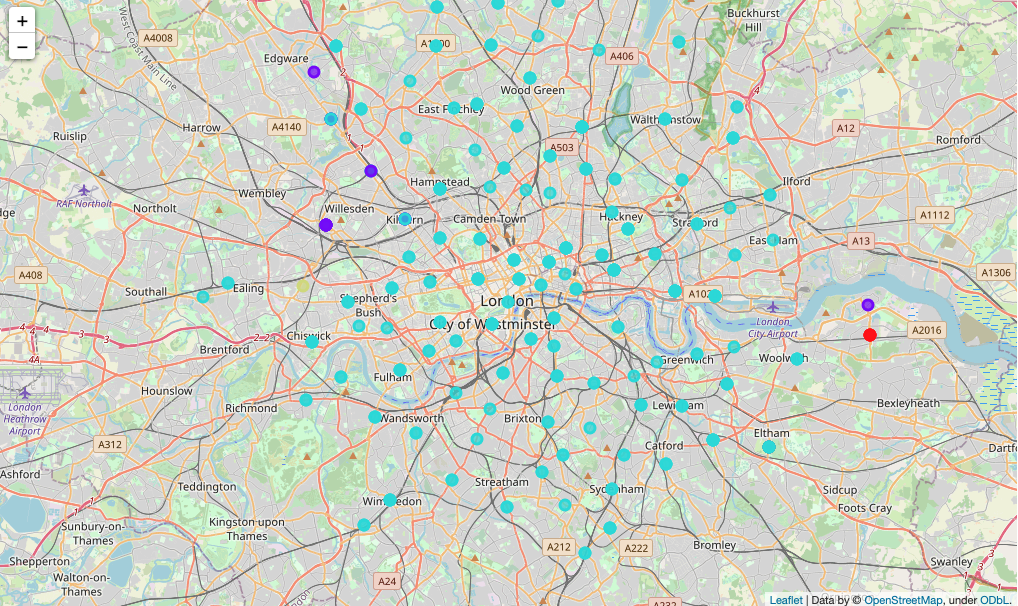

The following is the clustered map of New York City:

In [131]:
map_clusters_NY= folium.Map(location=[ny_latitude, ny_longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(k_num_clusters)
ys = [i + x + (i*x)**2 for i in range(k_num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ny_DF['Latitude'], ny_DF['Longitude'], ny_DF['Borough'], 
                                  ny_DF['Cluster Labels']):
    label = folium.Popup('Cluster ' + str(int(cluster) +1) + '\n' + str(poi) , parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-2)],
        fill=True,
        fill_opacity=0.7,
        fill_color=rainbow[int(cluster-2)]
        ).add_to(map_clusters_NY)
        
map_clusters_NY

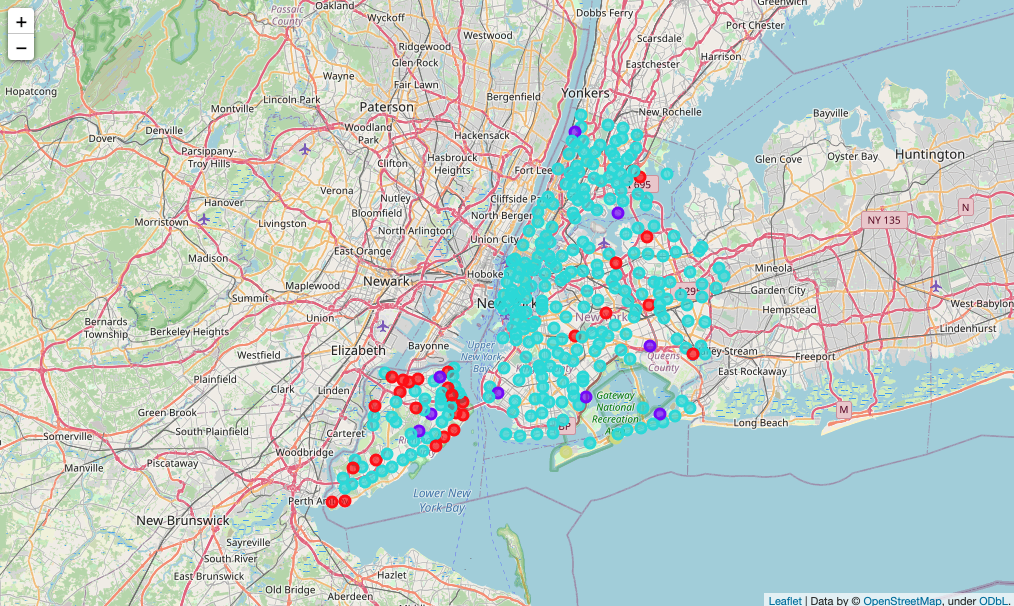

### 3.9.1 Examine Clusters

The next step is to look at the clusters by expanding the code to use the Cluster Labels column. We will first take a look at the four clusters of London:

In [108]:
# cluster 1 
london_DF.loc[london_DF['Cluster Labels'] == 1, london_DF.columns[[1] + list(range(5, london_DF.shape[1]))]]


Town  Cluster Labels 1th Most Common Venue  \
0                 LONDON               1           Supermarket   
25   BEXLEYHEATH, LONDON               1           Supermarket   
71                LONDON               1           Supermarket   
165       LONDON, SIDCUP               1           Supermarket   
290               LONDON               1           Supermarket   

    2th Most Common Venue 3th Most Common Venue 4th Most Common Venue  \
0           Train Station     Convenience Store              Platform   
25          Historic Site              Platform     Convenience Store   
71          Historic Site              Platform     Convenience Store   
165         Historic Site              Platform     Convenience Store   
290         Historic Site              Platform     Convenience Store   

    5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0           Historic Site           Zoo Exhibit     Fish & Chips Shop   
25          Train Station              Bus Stop                  Park   
71          Train Station              Bus Stop                  Park   
165         Train Station              Bus Stop                  Park   
290         Train Station              Bus Stop                  Park   

          8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0            Falafel Restaurant        Farmers Market   Fast Food Restaurant  
25   Construction & Landscaping           Golf Course    Filipino Restaurant  
71   Construction & Landscaping           Golf Course    Filipino Restaurant  
165  Construction & Landscaping           Golf Course    Filipino Restaurant  
290  Construction & Landscaping           Golf Course    Filipino Restaurant

In [109]:
# cluster 2
london_DF.loc[london_DF['Cluster Labels'] == 2, london_DF.columns[[1] + list(range(5, london_DF.shape[1]))]]


Town  Cluster Labels 1th Most Common Venue  \
35                            LONDON               2     Indian Restaurant   
40                            LONDON               2     Indian Restaurant   
61                            LONDON               2     Indian Restaurant   
80                            LONDON               2     Indian Restaurant   
92                   LONDON, WELLING               2              Bus Stop   
123                           LONDON               2     Indian Restaurant   
143                           LONDON               2     Indian Restaurant   
150                           LONDON               2     Indian Restaurant   
183                           LONDON               2     Indian Restaurant   
202                           LONDON               2          Liquor Store   
213                           LONDON               2     Indian Restaurant   
214  HARROW, STANMOREEDGWARE, LONDON               2              Bus Stop   
251                           LONDON               2     Indian Restaurant   
260                    LONDON, ERITH               2              Bus Stop   
299                           LONDON               2     Indian Restaurant   

    2th Most Common Venue       3th Most Common Venue 4th Most Common Venue  \
35               Pharmacy              Discount Store  Fast Food Restaurant   
40               Pharmacy              Discount Store  Fast Food Restaurant   
61               Pharmacy              Discount Store  Fast Food Restaurant   
80               Pharmacy              Discount Store  Fast Food Restaurant   
92                Daycare  Construction & Landscaping          Food Service   
123              Pharmacy              Discount Store  Fast Food Restaurant   
143              Pharmacy              Discount Store  Fast Food Restaurant   
150              Pharmacy              Discount Store  Fast Food Restaurant   
183              Pharmacy              Discount Store  Fast Food Restaurant   
202              Bus Stop          Chinese Restaurant  Fast Food Restaurant   
213              Pharmacy              Discount Store  Fast Food Restaurant   
214     Indian Restaurant         Fried Chicken Joint                Bakery   
251              Pharmacy              Discount Store  Fast Food Restaurant   
260               Daycare  Construction & Landscaping          Food Service   
299              Pharmacy              Discount Store  Fast Food Restaurant   

    5th Most Common Venue 6th Most Common Venue       7th Most Common Venue  \
35        Warehouse Store        Sandwich Place                    Bus Stop   
40        Warehouse Store        Sandwich Place                    Bus Stop   
61        Warehouse Store        Sandwich Place                    Bus Stop   
80        Warehouse Store        Sandwich Place                    Bus Stop   
92         Massage Studio           Golf Course               Historic Site   
123       Warehouse Store        Sandwich Place                    Bus Stop   
143       Warehouse Store        Sandwich Place                    Bus Stop   
150       Warehouse Store        Sandwich Place                    Bus Stop   
183       Warehouse Store        Sandwich Place                    Bus Stop   
202        Discount Store       Warehouse Store           Convenience Store   
213       Warehouse Store        Sandwich Place                    Bus Stop   
214                   Gym         Metro Station  Construction & Landscaping   
251       Warehouse Store        Sandwich Place                    Bus Stop   
260        Massage Studio           Golf Course               Historic Site   
299       Warehouse Store        Sandwich Place                    Bus Stop   

    8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
35      Convenience Store          Liquor Store     Chinese Restaurant  
40      Convenience Store          Liquor Store     Chinese Restaurant  
61      Convenience Store         

In [110]:
# cluster 3 
london_DF.loc[london_DF['Cluster Labels'] == 3, london_DF.columns[[1] + list(range(5, london_DF.shape[1]))]]

Town  Cluster Labels 1th Most Common Venue  \
2                    LONDON               3                 Hotel   
3                    LONDON               3                 Hotel   
4                    LONDON               3           Supermarket   
5                    LONDON               3           Coffee Shop   
6                    LONDON               3           Coffee Shop   
..                      ...             ...                   ...   
303                  LONDON               3           Coffee Shop   
304  LONDON, WOODFORD GREEN               3                 Hotel   
305                  LONDON               3           Coffee Shop   
306                  LONDON               3                   Pub   
307                  LONDON               3                   Pub   

    2th Most Common Venue 3th Most Common Venue 4th Most Common Venue  \
2             Coffee Shop    Italian Restaurant  Gym / Fitness Center   
3             Coffee Shop                   Pub                  Café   
4       Convenience Store  Fast Food Restaurant                 Hotel   
5                     Pub                  Café            Food Truck   
6                     Pub                  Café            Food Truck   
..                    ...                   ...                   ...   
303                   Pub         Grocery Store                  Café   
304               Theater   Monument / Landmark                  Café   
305                  Café         Grocery Store                   Pub   
306         Grocery Store              Bus Stop     Indian Restaurant   
307                  Café           Coffee Shop         Grocery Store   

    5th Most Common Venue  6th Most Common Venue       7th Most Common Venue  \
2                     Pub               Wine Bar              Sandwich Place   
3          Sandwich Place     Italian Restaurant                     Theater   
4           Grocery Store                   Café                        Park   
5      Italian Restaurant  Vietnamese Restaurant                        Park   
6      Italian Restaurant  Vietnamese Restaurant                        Park   
..                    ...                    ...                         ...   
303              Pharmacy              BBQ Joint                 Pizza Place   
304                Garden                    Pub                       Plaza   
305           Supermarket     Italian Restaurant                    Pharmacy   
306                  Pier            Coffee Shop  Construction & Landscaping   
307                 Hotel              Gastropub                      Bakery   

    8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
2              Restaurant          Cocktail Bar      French Restaurant  
3               Hotel Bar            Restaurant           Burger Joint  
4                Bus Stop             Gastropub                 Bistro  
5                   Hotel          Cocktail Bar   Gym / Fitness Center  
6                   Hotel          Cocktail Bar   Gym / Fitness Center  
..                    ...                   ...                    ...  
303         Metro Station                  Park     Seafood Restaurant  
304              Pharmacy                Bakery            Art Gallery  
305    Turkish Restaurant           Pizza Place     Chinese Restaurant  
306                  Café    Chinese Restaurant         Clothing Store  
307       Thai Restaurant    Italian Restaurant                   Park  

[287 rows x 12 columns]

In [111]:
# cluster 4
london_DF.loc[london_DF['Cluster Labels'] == 4, london_DF.columns[[1] + list(range(5, london_DF.shape[1]))]]

Town  Cluster Labels 1th Most Common Venue 2th Most Common Venue  \
1  LONDON               4         Grocery Store        Breakfast Spot   

  3th Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
1         Train Station                  Park     Indian Restaurant   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
1            Food Stand   Filipino Restaurant           Event Space   

  9th Most Common Venue 10th Most Common Venue  
1               Exhibit     Falafel Restaurant

Now we look at the clusters of Manhattan:

In [132]:
# cluster 1
ny_DF.loc[ny_DF['Cluster Labels'] == 1, ny_DF.columns[[1] + list(range(5, ny_DF.shape[1]))]]

Neighborhood 1th Most Common Venue 2th Most Common Venue  \
29       Country Club        Sandwich Place    Italian Restaurant   
89         Ocean Hill         Deli / Bodega                Bakery   
144          Glendale   Arts & Crafts Store         Deli / Bodega   
150        Whitestone          Dance Studio         Deli / Bodega   
159         Briarwood         Deli / Bodega            Playground   
193        Brookville          Home Service         Deli / Bodega   
195      North Corona         Deli / Bodega                Bakery   
198      New Brighton         Deli / Bodega              Bus Stop   
202       Grymes Hill               Dog Run         Deli / Bodega   
204       South Beach                  Pier         Deli / Bodega   
205     Port Richmond   Rental Car Location         Deli / Bodega   
206  Mariner's Harbor    Italian Restaurant         Deli / Bodega   
217       Tottenville    Italian Restaurant        Cosmetics Shop   
224         Park Hill              Bus Stop    Athletics & Sports   
226      Graniteville         Moving Target              Bus Stop   
227         Arlington         Boat or Ferry         Deli / Bodega   
228          Arrochar              Bus Stop         Deli / Bodega   
229          Grasmere              Bus Stop         Grocery Store   
232     Midland Beach         Deli / Bodega                 Beach   
234    New Dorp Beach    Italian Restaurant         Deli / Bodega   
238      Butler Manor        Baseball Field                  Pool   
241     Arden Heights           Pizza Place         Deli / Bodega   
245        Bloomfield     Recreation Center          Burger Joint   
252       Shore Acres    Italian Restaurant              Bus Stop   
258          Elm Park         Deli / Bodega    Italian Restaurant   
285       Willowbrook              Bus Stop    Chinese Restaurant   
286      Sandy Ground              Bus Stop             Racetrack   
305         Fox Hills              Bus Stop        Sandwich Place   

    3th Most Common Venue            4th Most Common Venue  \
29     Chinese Restaurant                         Bus Stop   
89               Bus Stop  Southern / Soul Food Restaurant   
144               Brewery                Food & Drink Shop   
150           Candy Store                  Bubble Tea Shop   
159           Bus Station                            Plaza   
193         Women's Store                      Fish Market   
195  Gym / Fitness Center                      Pizza Place   
198                  Park                    Bowling Alley   
202                   Gym                    Women's Store   
204                 Beach                         Bus Stop   
205            Donut Shop                      Pizza Place   
206           Supermarket               Athletics & Sports   
217    Mexican Restaurant                         Bus Stop   
224                 Hotel                      Coffee Shop   
226         Grocery Store                    Women's Store   
227          Intersection              American Restaurant   
228           Pizza Place               Italian Restaurant   
229                  Bank                       Bagel Shop   
232              Bus Stop                       Restaurant   
234        Scenic Lookout                             Food   
238           Gas Station                         Bus Stop   
241              Pharmacy                      Coffee Shop   
245            Theme Park                         Bus Stop   
252                   Bar                     Intersection   
258   American Restaurant                   Ice Cream Shop   
285           Pizza Place                     Intersection   
286           Art Gallery                       Food Truck   
305         Grocery Store                    Women's Store   

      5th Most Common Venue     6th Most Common Venue  7th Most Common Venue  \
29                    Trail                Playground     Athletics & Sports   
89        Convenience Store        Mexican Resta

In [133]:
# cluster 2
ny_DF.loc[ny_DF['Cluster Labels'] == 2, ny_DF.columns[[1] + list(range(5, ny_DF.shape[1]))]]

Neighborhood 1th Most Common Venue 2th Most Common Venue  \
4           Riverdale                  Park           Bus Station   
27       Clason Point                  Park              Bus Stop   
81      Dyker Heights           Golf Course          Burger Joint   
91       Bergen Beach       Harbor / Marina                  Park   
148  South Ozone Park                  Park                 Hotel   
192        Somerville                  Park      Business Service   
203         Todt Hill                  Park         Women's Store   
256     Randall Manor                  Park                 Beach   
287       Egbertville    Italian Restaurant        Clothing Store   

    3th Most Common Venue      4th Most Common Venue 5th Most Common Venue  \
4              Food Truck               Home Service                 Plaza   
27          Grocery Store  South American Restaurant                  Pool   
81                   Park                 Bagel Shop                 Plaza   
91           Hockey Field         Athletics & Sports            Playground   
148        Sandwich Place                        Bar          Home Service   
192         Women's Store                Flea Market            Eye Doctor   
203           Fish Market                    Exhibit            Eye Doctor   
256              Bus Stop               Home Service         Women's Store   
287        Cosmetics Shop                       Park         Women's Store   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
4    Medical Supply Store        Baseball Field                  Bank   
27      Convenience Store         Boat or Ferry            Food Stand   
81             Playground           Fish Market            Eye Doctor   
91         Baseball Field         Women's Store                 Field   
148         Deli / Bodega  Fast Food Restaurant            Food Truck   
192               Factory    Falafel Restaurant                  Farm   
203               Factory    Falafel Restaurant                  Farm   
256     Fish & Chips Shop            Eye Doctor               Factory   
287     Fish & Chips Shop               Exhibit            Eye Doctor   

    9th Most Common Venue 10th Most Common Venue  
4                     Gym             Eye Doctor  
27             Food Truck             Eye Doctor  
81                Factory     Falafel Restaurant  
91            Event Space                Exhibit  
148            Donut Shop                   Food  
192        Farmers Market   Fast Food Restaurant  
203        Farmers Market   Fast Food Restaurant  
256    Falafel Restaurant                   Farm  
287               Factory     Falafel Restaurant

In [134]:
# cluster 3
ny_DF.loc[ny_DF['Cluster Labels'] == 3, ny_DF.columns[[1] + list(range(5, ny_DF.shape[1]))]]

Neighborhood 1th Most Common Venue 2th Most Common Venue  \
0       Wakefield              Pharmacy            Donut Shop   
1      Co-op City        Baseball Field           Bus Station   
2     Eastchester  Caribbean Restaurant         Deli / Bodega   
3       Fieldston           Music Venue           Bus Station   
5     Kingsbridge           Pizza Place                   Bar   
..            ...                   ...                   ...   
300       Erasmus  Caribbean Restaurant         Grocery Store   
301  Hudson Yards  Gym / Fitness Center   American Restaurant   
302       Hammels                 Beach              Building   
303     Bayswater            Playground         Women's Store   
304  Queensbridge                 Hotel        Baseball Field   

    3th Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0    Caribbean Restaurant         Deli / Bodega            Laundromat   
1     Fried Chicken Joint            Restaurant      Basketball Court   
2             Bus Station                 Diner    Seafood Restaurant   
3                   River                 Plaza         Women's Store   
5                  Bakery        Sandwich Place    Mexican Restaurant   
..                    ...                   ...                   ...   
300              Pharmacy           Yoga Studio           Music Venue   
301                 Hotel                  Café    Italian Restaurant   
302                 Diner  Gym / Fitness Center            Shoe Store   
303  Ethiopian Restaurant           Event Space               Exhibit   
304             Hotel Bar           Beer Garden        Scenic Lookout   

         6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0                 Dessert Shop        Sandwich Place                  Food   
1                   Bagel Shop         Grocery Store          Liquor Store   
2                  Pizza Place    Chinese Restaurant         Metro Station   
3                  Fish Market               Exhibit            Eye Doctor   
5    Latin American Restaurant    Spanish Restaurant           Supermarket   
..                         ...                   ...                   ...   
300          Health Food Store  Gym / Fitness Center     Mobile Phone Shop   
301                        Gym            Restaurant           Coffee Shop   
302                    Dog Run  Fast Food Restaurant            Food Truck   
303                 Eye Doctor               Factory    Falafel Restaurant   
304           Basketball Court          Cocktail Bar                  Park   

    9th Most Common Venue 10th Most Common Venue  
0          Ice Cream Shop                  Field  
1                   Trail               Pharmacy  
2    Fast Food Restaurant        Automotive Shop  
3                 Factory     Falafel Restaurant  
5     Fried Chicken Joint                   Café  
..                    ...                    ...  
300           Supermarket             Food Truck  
301               Dog Run                   Park  
302              Bus Stop            Bus Station  
303                  Farm         Farmers Market  
304        Sandwich Place              Roof Deck  

[266 rows x 11 columns]

In [135]:
# cluster 4
ny_DF.loc[ny_DF['Cluster Labels'] == 4, ny_DF.columns[[1] + list(range(5, ny_DF.shape[1]))]]

Neighborhood 1th Most Common Venue 2th Most Common Venue  \
172  Breezy Point                 Beach                 Trail   
179      Neponsit                 Beach         Women's Store   

    3th Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
172   Monument / Landmark         Women's Store           Fish Market   
179           Fish Market               Exhibit            Eye Doctor   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
172               Exhibit            Eye Doctor               Factory   
179               Factory    Falafel Restaurant                  Farm   

    9th Most Common Venue 10th Most Common Venue  
172    Falafel Restaurant                   Farm  
179        Farmers Market   Fast Food Restaurant

## 4. Results and Discussion
Based on the the cluster dataframes, it could be observed that London has a wide variety of amenities available. The neighborhoods of London could also be considered as multicultural as well, catering to a global group of citizens and tourists. This could be seen in the variety of cuisines available across the diffent clusters such as 
* Filipino restaurants
* Indian restaurants
* Chinese restaurants
* Vietnamese restaurants 
* Italian restaurants 
* French restaurants

and other food sources like fish & chip shops, sandwich places, dessert shops, bakeries, pubs, cafés, coffee shops, fast food restaurants, and many more options. There also seems to be a decent number of shopping options for groceries, flea markets, flower shops, clothing stores, fish markets, discount stores, and more. Travel methods like bus stops and train stations are also commonly available alongside other services such as massages, gyms, daycre, and pharmacies. For other leisure activities, there are parks, zoos, golf courses, and historic sites available for tourists to visit. Therefore, for tourists who come to London, we could see that there is a plethora of enteratining experiences plus services for people to easily dine and travel as well. So for people not as familiar with the city other than through media, they can easily visit and have a good time without worrying about a lack of resources throughout the different neighborhoods.

For New York City, we saw that there was a great cluster of neighborhoods squished into a small area of land compared to London. However, we found that despite the neighborhoods not being as widespread as those in London, it did not lack in its own diversity and list of options available for tourists and people residing in the city. For dining options, New York City had the options of 

* Italian restaurant
* Chinese restaurant
* Filipino restaurant
* Mexican restaurant
* American restaurant
* Mediterranean restaurnt
* Indian restaurant
* Latin American restaurant
* Middle Eastern restaurant
* Caribbean restaurant
* Korean restaurant
* Eastern European restaurant
* African restaurant
* Vietnamese restaurant

and they had several more alongside that already long list. Just from this, we could determine that New York City, in itself, has a longer list of options in dining that cater more to a wider global audience, whether they be tourists or residences living in the area. The city also has a beach option on top of hotels, music venues, baseball fields, farms, recreation centers and more which are not observed in our clusters for London. 

Therefore, from what we could see from comparing the two cities which are popularly depicted in various media sources like movies from our clustering anlaysis, we could see that though London has many options, it is not as updated as New York City is. This was an interesting finding since we had expected them to be similar. However, this could also portray the general trend of what kind of tourists visit either city more and how these differences could affect future tourist attraction based. By having more diverse options that are commonly utilized within the cities, this could easily bring in more tourists than a lack of options, since tourists could decide to visit that city that has the options the tourist wish for. 

## 5. Conclusion
The purpose of this project was to explore both New York City and London since both are major cities that are commonly portrayed in movies, television shows, and literature. We explored both cities based on their neighborhoods and extrapolated the common venues present in each neighborhoods. Then, we clustered the similar neighborhoods together. 

From our data, we observed that the neighborhoods in both cities did have a wide variety of options and experiences available for tourists. There was a strong cultural diversity in their options as well. However, New York city was deemed to be more of a multicultural city than London based on the options of dining and other amenities alone. For instance, we did not see hospitals and hotels as much in London compared to New York City. 

Despite this, both cities offer a vacation stay with various places to explore and amazing food. However, New York City might prove to be more attractive to tourists who wish to experience a wide variety of things since they have several more options not available in London. In conclusion, however, it is ultimately up to the tourists to make the decision of which city they would prefer if they wished to travel to a city based on solely the media portrayal of that location. 